### 1. Data Import and Base Variable 확인
#### 1) Data Import and DataFrame
* 데이터 분석을 위해, dataframe을 생성하는 가장 일반적인 방법
    * notebook 파일을 생성한 폴더에 분석하고자 하는 data파일을(e.g. csv) 옮겨둔다.
    * data를 notebook으로 import.
    * pandas 명령어로 data를 dataframe으로 생성.
    * *tip : github는 push 할 수 있는 파일 1개 최대 용량이 100mb이므로 csv파일을 push할 경우 error발생  
github에 csv은 push 못하므로, csv 파일은 add 하지말고 ipynb(주피터노트북파일 확장자) 파일만 add *
***
* 바로 dataframe을 만들지 않는 이유
    * df을 여러 종류 만들 가능성(dfx,dfy 등)이 있기 때문에 이를 구분하기 위함  
    * 또한 사용된 dataframe이 어떤 주제 및 소재인지를 표시
     ***
    * data를 dataframe으로 직접 생성  
    df = pd.read_csv('train.csv')  
    ***
    * data와 dataframe을 각각 생성  
    아래에서 사용되는 df은 taxi와 관련된 data로 만들어진 dataframe이다.  
    *taxi를 dataframe의 name으로는 못 씀.   이미 data를 taxi로 정의함  
    하나의 이름을 data로 쓰는 경우와 dataframe으로 쓰는 경우를 명확하게 구분하기 위함*  
    taxi = 'train.csv'  
    df = pd.read_csv(taxi)
    ***

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
taxi = 'train.csv' # data import
df = pd.read_csv(taxi) # dataframe 생성

#### 2) DataFrame 구조 및 변수정보
##### (1) data 및 dataframe
 - shape           : row, column 개수 확인
 - head(), tail()  : 데이터 확인
 - describe()      : 각 column별 간략한 통계정보 
 - info()          : 각 column별 타입 정보
 
##### (2) 변수정보
 * id : 식별자 for each trip
 * vendor_id : 공급자 코드(a code indicating the provider associated with the trip record)
 * pickup_datetime : 탑승 날짜 및 시각(date and time when the meter was engaged)
 * dropoff_datetime : 하차 날짜 및 시각(date and time when the meter was disengaged)
 * passengers in the vehicle : 승객수(driver entered value)
 * pickup_longitude : 탑승 경도(the longitude where the meter was engaged)
 * pickup_latitude : 탑승 위도(the latitude where the meter was engaged)
 * dropoff_longitude : 하차 경도(the longitude where the meter was disengaged)
 * dropoff_latitude : 하차 위도(the latitude where the meter was disengaged)
 * store_and_fwd_flag : 차량메모리 보관여부(this flage indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server. Y = store and forward, N = not a store and forward trip)
 * trip_duration : duration of the trip in seconds

In [3]:
df.shape # observation 및 column(변수) 갯수 확인

(701778, 11)

In [4]:
df.head() # data확인(head() 위 5개, tail() 아래 5개)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3495688,1,4/30/16 23:59,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454
1,id3051282,1,4/30/16 23:59,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409
2,id0082851,1,4/30/16 23:59,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081
3,id0515725,2,4/30/16 23:58,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800
4,id1872374,2,4/30/16 23:58,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151


In [8]:
df.describe() # 변수별 기초통계량 확인(mean과 50%비교, real변수와 category변수 확인)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,7.017780e+05
mean,1.536037,1.666577,-73.973665,40.750969,-73.973583,40.751836,9.387318e+02
std,0.498700,1.319466,0.043910,0.033139,0.044214,0.037572,6.772504e+03
min,1.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991829,40.737400,-73.991325,40.735959,3.900000e+02
50%,2.000000,1.000000,-73.981789,40.754150,-73.979828,40.754478,6.480000e+02
75%,2.000000,2.000000,-73.967567,40.768246,-73.963249,40.769691,1.047000e+03
max,2.000000,8.000000,-61.335529,43.486885,-61.335529,43.674000,3.526282e+06


In [9]:
df.info() # Variable Type 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 11 columns):
id                    701778 non-null object
vendor_id             701778 non-null int64
pickup_datetime       701778 non-null object
dropoff_datetime      701778 non-null object
passenger_count       701778 non-null int64
pickup_longitude      701778 non-null float64
pickup_latitude       701778 non-null float64
dropoff_longitude     701778 non-null float64
dropoff_latitude      701778 non-null float64
store_and_fwd_flag    701778 non-null object
trip_duration         701778 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 58.9+ MB


### 2. Data Pre-Processing
#### 1) Datatime Type Vriable Modify 

* **Datetime Type Conversion**
    * pickup_datetime, dropoff_datetime은 type이 datetime이어야 시간변수로 활용할 수  
    있으나, object(=string)임
    * 시간변수로 활용하기 위해 type을 datetime으로 바꿔줘야 함
    * pandas의 to_datetime을 활용해 type을 datetime으로 바꿔줄 수 있음
    * datafrme의 변수타입을 변경하는 코드는 다음과 같음
        * 방법 1  
        taxi_df.pickup_datetime = pd.to_datetime(taxi_df.pickup_datetime)  
        * 방법 2  
        taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime']) 
    * dataframe에서 새로운 변수를 생성할 경우 등호(=)의 오른쪽은 df.변수명, df['변수명']  
    둘다 상관 없으나, 새로운 변수명(왼쪽)은 df['변수명']으로 적어야 생성됨  
    새로운 변수명(왼쪽)을 df.변수명으로 적을 경우 kernel이 작동하지만 실제로 생성은 안됨

In [ ]:
df.pickup_datetime.dtype # 시간변수 type 확인

In [5]:
# 컴퓨터가 느릴 경우 여기서 샘플링
df = df.sample(frac = 0.1, replace = False, random_state = 0) # sampling
df.shape # sampling됐는지 확인

(70178, 11)

#### 2) Use the Pandas.Datetimeindex module
* dataframe_name.datetime_variable_name.dt.**option**  
**option**(year, month, day, hour, dayofyear, dayofweek 등)은 [참고링크](https://pandas.pydata.org/pandas-docs/stable/api.html#datetimeindex)에서 확인  
    * (e.g.)dayofweek = The day of the week with Monday=0, Sunday=6

***
* 특정 변수 생성(datetime variable에서 연, 월, 일 각각 변수로 분리)  
일 변수 : taxi_df['pickup_day'] = taxi_df.pickup_datetime.dt.day  
* 단위 변환한 변수 생성(week 기준 몇번째 일이냐, 요일 변수 생성)  
요일변수 : taxi_df['wday'] = taxi_df.pickup_datetime.dt.weekday

In [6]:
# 시간변수 type을 datetime type으로 변환(pandas datetimeIndex 이용)
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)

In [7]:
# 탄 시간, 일, 월, 연도를 카테고리 타입의 변수로 생성
df['pickup_hour'] = df.pickup_datetime.dt.hour.astype('category')
df['pickup_day'] = df.pickup_datetime.dt.day.astype('category')
df['pickup_month'] = df.pickup_datetime.dt.month.astype('category')
df['pickup_year'] = df.pickup_datetime.dt.year.astype('category')

In [8]:
# 연도, 주 기준 변수 생성
df['yday'] = df.pickup_datetime.dt.dayofyear.astype('category')
df['wday'] = df.pickup_datetime.dt.dayofweek.astype('category')
df['nwday'] = df.pickup_datetime.dt.weekday_name.astype('category')

In [9]:
df.vendor_id = df.vendor_id.astype('category') # vendor_id type category

In [ ]:
# 참고 skip
# pickup - dropoff의 계산을 통해 trip_duration 검증 및 pickup, dropoff, trip_duration 변수 관계 확인
#df.trip_duration_c = df.dropoff_datetime - df.pickup_datetime

# trip_duration_c는 day단위로 산출됨.
#df.trip_duration_c = df.trip_duration_c.dt.total_seconds() # second로 단위 변환

#### 3) Create Category Variable
* pickup_month가 1월 ~ 4월까지 밖에 없음(kaggledata는 6월까지)
* 1, 2, 3월은 겨울의 계절성을 반영하고, 4, 5, 6월은 봄 ~ 초여름의 계절성을 반영한다고 가정함.
    * 사람들이 기후조건이 가혹할수록 더 택시를 오래 타고 있는다고 가정(날이 추우면 최대한 목적지에 가까운 장소까지 택시를 타고 간다.)
    * 이 가정을 반영하기 위해서는 뉴욕의 날씨를 확인해서 비오는 날과 맑은 날, 날짜별 온도를 변수화해서 반영하는 것이 보다 정확할 것으로 생각함 
        * 변수 2개 생성(날짜별로 비 or 눈이 왔다 0 나머지 1, 기온이 00도 이상 or 00도 이하 0, 나머지 1)해서 pickup_datetime으로 merge.
    * 가장 rough하게 변수를 생성해서 모형을 실행한 다음 이 변수가 유의미할 경우 더 세밀하게 변수를 조정하는 것이 나을 듯함
    
    
* 계절성을 반영한 분기별 카테고리 변수(pickup_month_c) 생성 1, 2, 3월은 0, 4, 5, 6월은 1의 값을 가짐.

In [10]:
# 1, 2, 3월은 0, 4, 5, 6월은 1) 
df['pickup_month_c'] = df.pickup_month.replace([1, 2], '0')
df['pickup_month_c'] = df.pickup_month_c.replace([3, 4], '1')

df.pickup_month_c = df.pickup_month_c.astype('category')# type 변경(to category) 및 type 확인

In [11]:
# 월~금요일은 0, 토~일요일은 1
df['wday_c'] = df.pickup_month.replace([0, 1, 2, 3, 4], '0')
df['wday_c'] = df.pickup_month_c.replace([5, 6], '1')

df.wday_c = df.wday_c.astype('category')# type 변경(to category) 및 type 확인

In [12]:
# 일상, 여행으로 trip종류 구분(trip_duration이 60000(16시간)이상인 경우 여행)

def alert(df):
    if df['trip_duration'] <= 60000:
        return '0'
    elif df['trip_duration'] > 60000:
        return '1'
    
df['trip_c'] = df.apply(alert, axis = 1)
df.trip_c = df.trip_c.astype('category') # trip_c type category

In [13]:
# 그래프 패키지 import
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_color_codes()

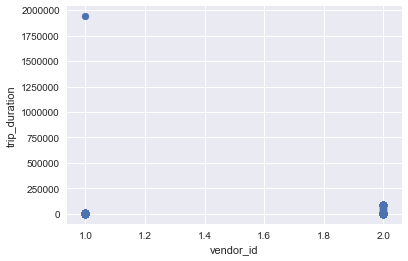

In [14]:
plt.scatter(df.vendor_id, df.trip_duration)
plt.xlabel("vendor_id")
plt.ylabel("trip_duration")
plt.show()

C:\Users\best0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


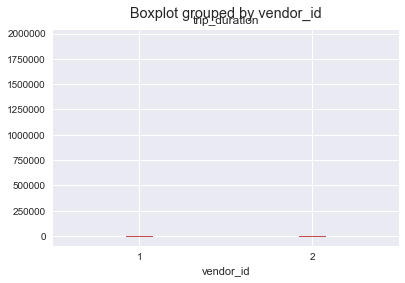

In [15]:
df.boxplot("trip_duration", "vendor_id")
plt.show()

C:\Users\best0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


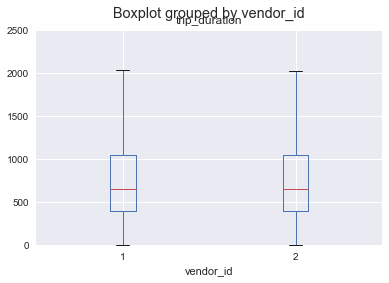

In [16]:
df.boxplot("trip_duration", "vendor_id")
plt.ylim(-10, 2500)
plt.show()

* *참고 : boxplot 보는 방법*
<img src="boxplot-1.png">
* *참고 : 그래프 저장 방법*  
from pylab import figure, axes, pie, title, savefig #savefig추가  
savefig('boxplot.png') # graph 이미지 저장

* *Sampling  (위에서 했으니까 skip)*
    * 분석하거나 그래프 그릴 때 모든 데이터를 사용할 경우 수행시간이 너무 길어짐  
이에 sample 사용

In [22]:
month_group = df.groupby('pickup_month') # original data 확인을 위해 grouping

In [23]:
month_group.count() # pickup_month의 variable*column별 관측치 수 확인

# size함수를 통해 pickup_month의 value별 관측치 수 확인(count와 size의 차이 : size는 NaN값을 포함해서 세고, count는 NaN값을 세지 않음)
# month_group.size().sort_values(ascending = False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_year,yday,wday,nwday,pickup_month_c,wday_c,trip_c
pickup_month,,,,,,,,,,,,,,,,,,,,
1,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473,16473
2,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383,17383
3,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328,18328
4,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994,17994


In [ ]:
# 위에서 했으므로 여기서는 실행 안함. 원래 여기서 시행해야 아래 표와 차이 발생
# df = df.sample(frac = 0.1, replace = False, random_state = 0) # sampling
# df.shape # sampling됐는지 확인

In [ ]:
# sample이 골고루 뽑혔는지 확인
# month_group.count()의 output과 비교. 월별 갯수 비중 확인

# pickup_month data 확인을 위해 grouping
month_group = df.groupby('pickup_month')
# pickup_month의 variable*column별 관측치 수 확인
month_group.count()

#### 4) data log 변환
* trip_duration의 단위는 second로 log변환 가능
* trip_duration에 +1(scaling)을 한 후 log 변환 수행  
*original 값에 +1을 하는 이유 :
original 값이 0인 경우 log변환하면 1이 되어버림 따라서, 모든 original 값에 1을 더함*
* tirp_duraiont+1을 log변환 함
* original 값과 log변환 값 비교

In [17]:
df['logtrip_duration'] = np.log(df.trip_duration + 1)

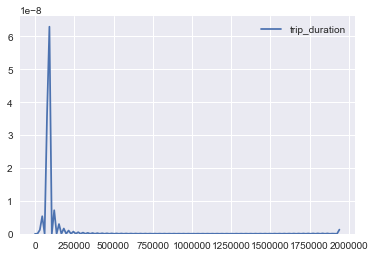

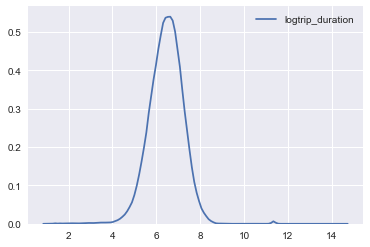

In [18]:
sns.kdeplot(df.trip_duration) # kernel density grahp (높이(x가 뽑힐 확률)는 큰 의미 없음, 넓이가 중요(넓이의 합은 1))
plt.show()
sns.kdeplot(df.logtrip_duration) # 정규분포와 더 유사한 분포가 됨
plt.show()

C:\Users\best0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


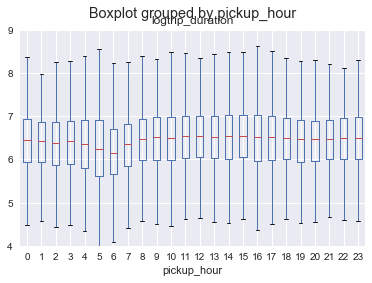

In [19]:
df.boxplot("logtrip_duration", "pickup_hour")
plt.ylim(4, 9)
plt.show()

In [49]:

# 탄 시간, 일, 월, 연도를 카테고리 타입의 변수로 생성
df['pickup_hour'] = df.pickup_datetime.dt.hour.astype('int')
df['pickup_day'] = df.pickup_datetime.dt.day.astype('int')
df['pickup_month'] = df.pickup_datetime.dt.month.astype('int')
df['pickup_year'] = df.pickup_datetime.dt.year.astype('int')
# 연도, 주 기준 변수 생성
df['yday'] = df.pickup_datetime.dt.dayofyear.astype('int')
df['wday'] = df.pickup_datetime.dt.dayofweek.astype('int')
df.vendor_id = df.vendor_id.astype('int') # vendor_id type category

In [48]:
#correlation 확인
df['logtrip_duration'].corr(df['trip_c'])

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [28]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day,pickup_month,pickup_year,yday,wday,nwday,pickup_month_c,wday_c,trip_c,logtrip_duration
241061,id3441354,1,2016-03-21 14:34:00,2016-03-21 14:50:00,1,-73.971970,40.761642,-73.991158,40.750072,N,...,21,3,2016,81,0,Monday,1,1,0,6.908755
685646,id0985993,2,2016-01-04 11:59:00,2016-01-04 12:11:00,1,-73.998474,40.745346,-73.988899,40.777729,N,...,4,1,2016,4,0,Monday,0,0,0,6.594413
431330,id0695961,1,2016-02-18 22:32:00,2016-02-18 22:56:00,3,-73.989792,40.746990,-73.960960,40.766827,N,...,18,2,2016,49,3,Thursday,0,0,0,7.304516
356863,id1113960,1,2016-03-02 13:41:00,2016-03-02 13:48:00,2,-73.979637,40.752895,-73.981476,40.759377,N,...,2,3,2016,62,2,Wednesday,1,1,0,6.115892
225044,id2878431,1,2016-03-24 10:59:00,2016-03-24 11:08:00,2,-73.994743,40.745583,-74.006577,40.732033,N,...,24,3,2016,84,3,Thursday,1,1,0,6.340359


In [22]:
install.packages("Hmisc")

NameError: name 'install' is not defined

In [70]:
#correlation 확인
df['logtrip_duration'].corr(df['trip_duration'])

0.19155341740756118

In [77]:
print(dfX.corr('pearson'))

                       pickup_month      wday  vendor_id  pickup_day  \
pickup_month               1.000000  0.001363  -0.008408   -0.018963   
wday                       0.001363  1.000000   0.007228    0.024508   
vendor_id                 -0.008408  0.007228   1.000000   -0.004991   
pickup_day                -0.018963  0.024508  -0.004991    1.000000   
pickup_hour                0.006336 -0.075864   0.011543    0.001308   
passenger_count           -0.002344  0.031310   0.285974   -0.003288   
average_temperature_y      0.605094 -0.015382  -0.010040    0.169235   
distance                   0.015505  0.012422   0.002873    0.006632   
speed                     -0.018950  0.068472  -0.000730   -0.017846   

                       pickup_hour  passenger_count  average_temperature_y  \
pickup_month              0.006336        -0.002344               0.605094   
wday                     -0.075864         0.031310              -0.015382   
vendor_id                 0.011543         0.

In [20]:
titanic_size = titanic.pivot_table(index="class", columns="embark_town", aggfunc="size")
titanic_size

NameError: name 'titanic' is not defined

In [78]:
df.set_index('wday', inplace=True)

In [80]:
df = df.reset_index()

In [81]:
df_trip = df.pivot_table(index="pickup_month", columns="pickup_hour", aggfunc="wday")

AttributeError: Cannot access attribute 'index' of 'SeriesGroupBy' objects, try using the 'apply' method

In [ ]:
from statsmodels.datasets.longley import load_pandas
dfy = load_pandas().endog
dfX0 = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX0)
plt.show()

In [ ]:
dfX0_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX_boston = sm.add_constant(dfX0_boston)

In [ ]:
dfX0 =  pd.DataFrame(taxi.data, columns = df)

In [82]:
sns.heatmap(df.speed, df.distance.corr())
plt.show()

TypeError: corr() missing 1 required positional argument: 'other'

In [75]:
sns.heatmap(, annot=True, fmt="d")
plt.show()

AttributeError: Cannot access attribute 'index' of 'SeriesGroupBy' objects, try using the 'apply' method

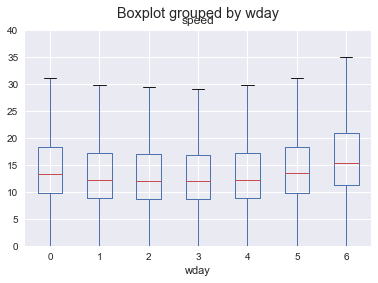

In [72]:
df.boxplot("speed", "wday")
plt.ylim(0, 40)
plt.show()

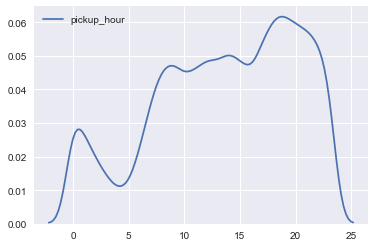

In [27]:
sns.kdeplot(df.pickup_hour) # kernel density grahp (높이(x가 뽑힐 확률)는 큰 의미 없음, 넓이가 중요(넓이의 합은 1))
plt.show()

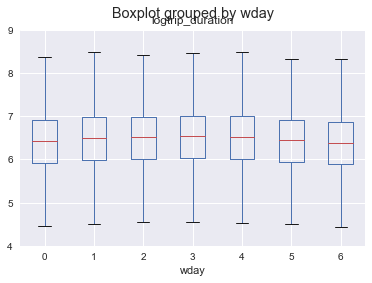

In [28]:
df.boxplot("logtrip_duration", "wday")
plt.ylim(4, 9)
plt.show()

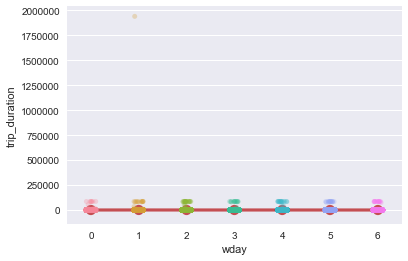

In [29]:
sns.stripplot(x="wday", y="trip_duration", data=df, jitter=True, alpha=.3)
sns.pointplot(x="wday", y="trip_duration", data=df, dodge=True, color='r')
plt.show()

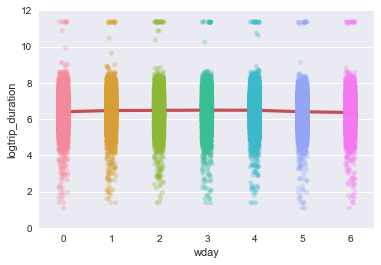

In [24]:
sns.stripplot(x="wday", y="logtrip_duration", data=df, jitter=True, alpha=.3)
sns.pointplot(x="wday", y="logtrip_duration", data=df, dodge=True, color='r')
plt.ylim(0, 12)
plt.show()

* 요일, logtrip_duration, 탑승 시각을 그래프로 확인

In [66]:
sns.stripplot(x="distance", y="speed", hue = "wday", data = df, jitter = True)
plt.ylim(0, 12)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
plt.show()

KeyboardInterrupt: 

#### tip : 기존 dataframe에 변수를 추가했을 때 활용할 수 있는 명령어(변수명 변경, 변수 삭제, 변수 순서 변경)
* 변수명(column) 변경(rename)
    * 방법1 : df = df.rename(columns = {'oldname1' : 'newname1', 'oldname2' : 'newname2'})
    * 방법2 : df.rename(columns = {'oldname1' : 'newname1', 'oldname2' : 'newname2'}, inplace = True)
* 잘못 생성한 변수(column) 삭제(drop)
    * 방법1 : df = df.drop('column_name', axis = 1)  
    *axis = 1은 dataframe의 column을 의미(0은 row)*
    * 방법2 : df.drop('column_name', axis = 1, inplace = True)
* 변수(column) 순서 변경(order or insert)
    * 방법1 : df = df.[['column1', 'column2']]
    * 방법2 : 특정자리에 특정 변수 삽입
        * get a list of columns   
        cols = list(df)
        * move the column to head of list using index, pop and insert  
        cols.insert(0, cols.pop(cols.index('column_name')))
        * use loc to reorder(라벨을 활용할 경우 loc, 위치 index를 활용할 경우 iloc)  
        df = df.loc[:, cols]                  

In [75]:
# 변수 순서 조정
cols = list(df) # dataframe을 list로 type변환 -> 변수명만 포함한 리스트(cols) 생성
cols.insert(0, cols.pop(cols.index('trip_duration'))) # 종속변수를 잘라내어(pop) cols맨 앞(index 0)에 삽입(insert)
cols.insert(1, cols.pop(cols.index('logtrip_duration')))
cols.insert(2, cols.pop(cols.index('pickup_month'))) # 독립변수1를 잘라내어(pop) index 2에 삽입(insert)
cols.insert(3, cols.pop(cols.index('wday')))
cols.insert(4, cols.pop(cols.index('vendor_id')))
cols.insert(5, cols.pop(cols.index('pickup_day')))
cols.insert(6, cols.pop(cols.index('pickup_hour')))
cols.insert(7, cols.pop(cols.index('passenger_count')))
cols.insert(8, cols.pop(cols.index('trip_c')))
cols.insert(9, cols.pop(cols.index('pickup_month_c')))
cols.insert(10, cols.pop(cols.index('wday_c')))
cols.insert(11, cols.pop(cols.index('average_temperature_y')))
cols.insert(12, cols.pop(cols.index('distance')))
cols.insert(13, cols.pop(cols.index('speed')))

df = df.loc[:, cols] # 행은 그대로, 열은 cols(변수명 리스트)로 다시 구성

In [ ]:
clos_real = ['passenger_count' ]

In [37]:
cols_cat = ['vendor_id', 'pickup_month', 'wday', 'pickup_hour', 'trip_c']

In [44]:
df.head()

,trip_duration,logtrip_duration,pickup_month,wday,vendor_id,pickup_day,pickup_hour,passenger_count,trip_c,pickup_month_c,...,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,yday,nwday
241061,1000,6.908755,3,0,1,21,14,1,0,1,...,2016-03-21 14:34:00,2016-03-21 14:50:00,-73.971970,40.761642,-73.991158,40.750072,N,2016,81,Monday
685646,730,6.594413,1,0,2,4,11,1,0,0,...,2016-01-04 11:59:00,2016-01-04 12:11:00,-73.998474,40.745346,-73.988899,40.777729,N,2016,4,Monday
431330,1486,7.304516,2,3,1,18,22,3,0,0,...,2016-02-18 22:32:00,2016-02-18 22:56:00,-73.989792,40.746990,-73.960960,40.766827,N,2016,49,Thursday
356863,452,6.115892,3,2,1,2,13,2,0,1,...,2016-03-02 13:41:00,2016-03-02 13:48:00,-73.979637,40.752895,-73.981476,40.759377,N,2016,62,Wednesday
225044,566,6.340359,3,3,1,24,10,2,0,1,...,2016-03-24 10:59:00,2016-03-24 11:08:00,-73.994743,40.745583,-74.006577,40.732033,N,2016,84,Thursday


In [45]:
dfX_cat = dfX[cols_cat]
print(len(dfX_cat.columns))
dfX_cat.tail()

KeyError: "['vendor_id' 'pickup_month' 'wday' 'pickup_hour' 'trip_c'] not in index"

In [76]:
dfy = df.ix[:,1:2]
dfX = df.ix[:,2:14]
print(len(dfy.columns), len(dfX.columns))

1 12


C:\Users\best0\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [34]:
dfX.corrwhith(dfX1)

AttributeError: 'DataFrame' object has no attribute 'corrwhith'

In [26]:
df.wday.corr(df.wday)

1.0

#### 5) Outlier 확인 및 삭제
##### (1) Outlier를 직접 확인, 판단, 삭제
* outlier 삭제(trip_duration이 1750000초 이상인 경우 빈도가 매우 적고 숫자가 너무 커 outlier로 판단) 
* *trip_duration이 20,000초 이상(5시간 이상)인 경우는 일반적인 상황이 아닌 것(분석 data에서 제외)으로 고려하고 분석할 수 있을 것으로 판단*  

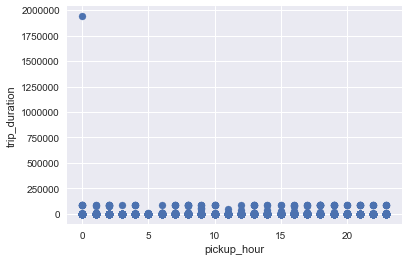

In [27]:
plt.scatter(df.pickup_hour, df.trip_duration)
plt.xlabel("pickup_hour")
plt.ylabel("trip_duration")
plt.show()

In [28]:
# 이상치라 판단되는 data확인
df[df.trip_duration >= 1750000]

# 아래의 형식으로도 확인 가능(특정 범위)
# df[(df.trip_duration >= 1750000) & (df.trip_duration <= 2000000)]

,trip_duration,logtrip_duration,pickup_month_c,wday_c,vendor_id,pickup_day,pickup_hour,passenger_count,trip_c,pickup_month,...,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,yday,nwday
682482,1939736,14.478063,0,0,1,5,0,1,1,1,...,2016-01-05 00:19:00,2016-01-27 11:08:00,-73.78965,40.643559,-73.95681,40.773087,N,2016,5,Tuesday


In [29]:
# 특정 관측치 삭제
#df = df.drop([682482])
#df = df.drop()(axis=0)

# 특정 범위만 grab
df = df[df.trip_duration <= 1750000]
#df[(df.trip_duration >= 1750000) & (df.trip_duration <= 2000000)]

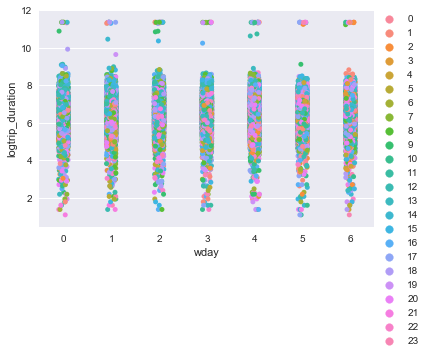

In [30]:
# 삭제되었는지 확인
sns.stripplot(x="wday", y="logtrip_duration", hue = "pickup_hour", data = df, jitter = True)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
plt.show()

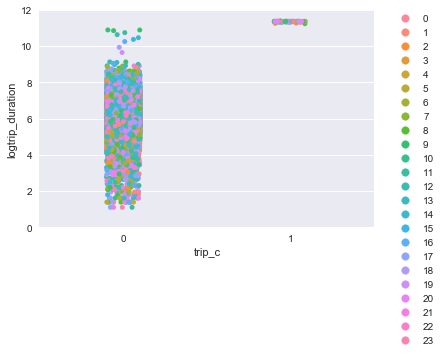

In [31]:
sns.stripplot(x="trip_c", y="logtrip_duration", hue = "pickup_hour", data = df, jitter = True)
plt.ylim(0, 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

* 2016년 뉴욕 날씨 데이터를 입력하여 yday를 기준변수로 활용하여 기존 data frame에 merge함

In [54]:
# 2016년 뉴욕 날씨 데이터 입력
wdf = pd.read_csv('weather_data_nyc_centralpark_2016.csv')

In [55]:
wdf['date'] = pd.to_datetime(wdf.date,format='%d-%m-%Y')
wdf['yday'] = wdf.date.dt.dayofyear
# wdf['wday'] = wdf.date.dt.dayofweek
# wday변수는 wdf에서 안만들어도 될 것 같아서 만들지 않음
# merge하는데 필요한 기준 변수는 1개면 충분하다고 판단함

In [56]:
# data확인결과 pricipitation 등의 변수에 숫자가 아닌 T가 있음
wdf.head(10)
# T는 측정되지 않았으나 비가왔던 흔적을 의미함
#"T" stands for "trace", used when precipitation has been detected, but it isn't sufficient to measure meaningfully.

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,yday
0,2016-01-01,42,34,38.0,0.00,0.0,0,1
1,2016-01-02,40,32,36.0,0.00,0.0,0,2
2,2016-01-03,45,35,40.0,0.00,0.0,0,3
3,2016-01-04,36,14,25.0,0.00,0.0,0,4
4,2016-01-05,29,11,20.0,0.00,0.0,0,5
5,2016-01-06,41,25,33.0,0.00,0.0,0,6
6,2016-01-07,46,31,38.5,0.00,0.0,0,7
7,2016-01-08,46,31,38.5,0.00,0.0,0,8
8,2016-01-09,47,40,43.5,T,0.0,0,9
9,2016-01-10,59,40,49.5,1.80,0.0,0,10


In [57]:
# T를 아주 작은 수로 바꿔줌(여기서는 0.01로 변경)
falls = [ 0 if c=='T' else float(c) for c in wdf['snow fall']]
rain = [ 0 if c=='T' else float(c) for c in wdf['precipitation']]
wdf['snow_fall']= falls
wdf['precipitation'] = rain
wdf = wdf.rename(columns = {'average temperature' : 'average_temperature'})

In [68]:
# 'yday' 변수를 기준변수로 taxi_df에 wdf를 merge함
# (yday를 기준으로 taxi_df에 wdf의 data를 가로로 붙인다.)
df = pd.merge(df,wdf,on='yday')
df

# 필요없는 변수 삭제(maximum과 minimum은 같은 지역으로 다 같기 때문에 삭제)
df = df.drop(['date','maximum temperature','minimum temperature'], axis=1)
df.head()

,trip_duration,logtrip_duration,pickup_month,wday,vendor_id,pickup_day,pickup_hour,passenger_count,trip_c,pickup_month_c,...,snow fall_x,snow depth_x,snow_fall_x,distance,speed,average_temperature_y,precipitation_y,snow fall_y,snow depth_y,snow_fall_y
0,1000,6.908755,3,0,1,21,14,1,0,1,...,0.5,T,0.5,2.064433,7.431958,41.0,0.06,0.5,T,0.5
1,1014,6.922644,3,0,1,21,12,1,0,1,...,0.5,T,0.5,4.559980,16.189278,41.0,0.06,0.5,T,0.5
2,3949,8.281471,3,0,1,21,16,1,0,1,...,0.5,T,0.5,20.038639,18.267688,41.0,0.06,0.5,T,0.5
3,251,5.529429,3,0,1,21,15,1,0,1,...,0.5,T,0.5,0.948848,13.608978,41.0,0.06,0.5,T,0.5
4,844,6.739337,3,0,2,21,17,1,0,1,...,0.5,T,0.5,4.987093,21.271960,41.0,0.06,0.5,T,0.5


 ##### (2) 공간변수(or 지도정보, 위치정보) 사용 
  * 지도정보(위치정보)를 활용하기 위해서는 folium(포리움)함수를 사용해야 함

In [59]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [60]:
df['distance'] = haversine_np(df.pickup_longitude, df.pickup_latitude,
                                           df.dropoff_longitude, df.dropoff_latitude)

In [61]:
df['speed'] = df.distance / (df.trip_duration/3600)

In [62]:
df.distance.describe()

count    70178.000000
mean         3.393625
std          3.935435
min          0.000000
25%          1.222996
50%          2.067887
75%          3.815696
max        101.672421
Name: distance, dtype: float64

In [63]:
df.speed.describe()

count    70178.000000
mean        14.514581
std          7.940653
min          0.000000
25%          9.263413
50%         12.862914
75%         17.931619
max        267.768484
Name: speed, dtype: float64

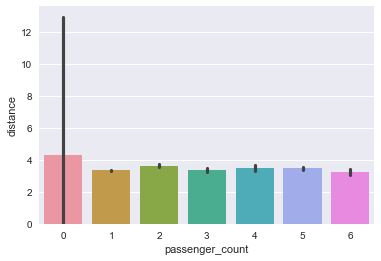

In [64]:
import seaborn as sns
#sns.set(style="ticks")
sel = df[['distance','passenger_count']]
sns.barplot(x='passenger_count',y='distance',data=sel)
#sns.despine(offset=10, trim=True)
plt.show()

In [65]:
# 이상치라 판단되는 data확인
df[df.passenger_count == 0]

# 아래의 형식으로도 확인 가능(특정 범위)
# df[(df.trip_duration >= 1750000) & (df.trip_duration <= 2000000)]

,trip_duration,logtrip_duration,pickup_month,wday,vendor_id,pickup_day,pickup_hour,passenger_count,trip_c,pickup_month_c,...,pickup_year,yday,nwday,average_temperature,precipitation,snow fall,snow depth,snow_fall,distance,speed
848,2251,7.719574,1,0,1,4,12,0,0,0,...,2016,4,Monday,25.0,0.00,0.0,0,0.0,12.950165,20.711059
59361,15,2.772589,1,1,2,5,18,0,0,0,...,2016,5,Tuesday,20.0,0.00,0.0,0,0.0,0.005934,1.424099
64358,45,3.828641,2,0,1,1,0,0,0,0,...,2016,32,Monday,51.5,0.01,0.0,2,0.0,0.000000,0.000000


In [66]:
# 특정 관측치 삭제
df = df.drop([848])
df = df.drop([59361])
df = df.drop([64357])
#df = df.drop()(axis=0)

# 특정 범위만 grab
#df = df[df.trip_duration <= 1750000]
#df[(df.trip_duration >= 1750000) & (df.trip_duration <= 2000000)]

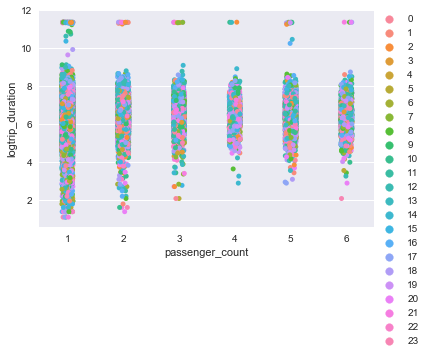

In [49]:
# 삭제되었는지 확인
sns.stripplot(x="passenger_count", y="logtrip_duration", hue = "pickup_hour", data = df, jitter = True)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
plt.show()

##### (2) OLS분석을 통해 Outlier 확인 및 삭제

* OLS를 통해 확인하는 방법
    * ols를 통해 레버리지와 잔차를 계산하여 이를 근거로 outlier 규정

In [52]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Users\best0\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [79]:
model = smf.ols(formula = "logtrip_duration ~ C(vendor_id)  + C(wday) + C(pickup_hour)+ precipitation_y + snow_fall_y + average_temperature_y + distance", data = df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       logtrip_duration   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     1429.
Date:                Fri, 20 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:47:12   Log-Likelihood:                -64078.
No. Observations:               70175   AIC:                         1.282e+05
Df Residuals:                   70140   BIC:                         1.285e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.79

In [61]:
sm.stats.anova_lm(result)

C:\Users\IS\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\IS\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\IS\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
C(vendor_id),1.0,9.116848,9.116848,34.818531,3.635683e-09
C(wday),6.0,154.382685,25.730448,98.268212,1.370478e-123
C(pickup_hour),23.0,341.348042,14.841219,56.680712,8.128333e-259
C(pickup_month),3.0,69.859321,23.286440,88.934203,1.951178e-57
precipitation_y,1.0,0.552096,0.552096,2.108533,1.464842e-01
snow_fall_y,1.0,1.895459,1.895459,7.239024,7.135263e-03
passenger_count,1.0,5.028340,5.028340,19.203942,1.176408e-05
average_temperature_y,1.0,11.389548,11.389548,43.498293,4.273308e-11
distance,1.0,17108.129818,17108.129818,65338.363401,0.000000e+00
speed,1.0,7145.599732,7145.599732,27290.054319,0.000000e+00


In [62]:
print("TSS = ", result.uncentered_tss)
print("ESS = ", result.mse_model)
print("RSS = ", result.ssr)
print("ESS + RSS = ", result.mse_model + result.ssr)
print("R squared = ", result.rsquared)

TSS =  2959312.64581
ESS =  637.110304864
RSS =  18364.8617242
ESS + RSS =  19001.9720291
R squared =  0.575007123265


In [63]:
import scipy as sp

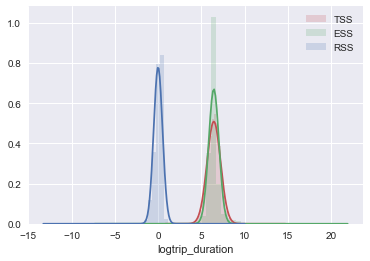

In [64]:
sns.distplot(df.logtrip_duration, 
             kde=False, fit=sp.stats.norm, hist_kws={"color": "r", "alpha": 0.2}, fit_kws={"color": "r"}, 
             label="TSS")
sns.distplot(result.fittedvalues, 
             kde=False, hist_kws={"color": "g", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "g"}, 
             label="ESS")
sns.distplot(result.resid, 
             kde=False, hist_kws={"color": "b", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "b"}, 
             label="RSS")
plt.legend()
plt.show()